Validate that preprocessed data meets YAMNet specifications:
- Sample rate: 16kHz
- Frame duration: 0.96s (15,360 samples)
- Format: mono audio
- Amplitude range: [-1, 1]

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import librosa
import librosa.display

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

PROCESSED_DIR = '../data/processed'
METADATA_PATH = os.path.join(PROCESSED_DIR, 'processed_frames_metadata.csv')
TARGET_SR = 16000
EXPECTED_FRAME_SAMPLES = 15360  # 0.96s at 16kHz
CATEGORIES = ['Alarm_Clock', 'Car_Horn', 'Glass_Breaking', 'Gunshot', 'Siren']

In [ ]:
# LOAD METADATA
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Metadata not found: {METADATA_PATH}")

df = pd.read_csv(METADATA_PATH)
print(f"\nLoaded metadata: {len(df)} frames")
print(f"Categories: {df['category'].nunique()}")
print(f"Original files: {df['original_file'].nunique()}")


Loaded metadata: 11906 frames
Categories: 5
Original files: 802


In [ ]:
# CLASS DISTRIBUTION
print("CLASS DISTRIBUTION")

class_counts = df['category'].value_counts().sort_index()
print("\nFrames per category:")
for cat, count in class_counts.items():
    orig = len(df[(df['category'] == cat) & (df['aug_idx'] == 0)])
    aug = count - orig
    percentage = (count / len(df)) * 100
    print(f"  {cat:15s}: {count:5d} ({percentage:5.2f}%) | {orig} orig + {aug} aug")

CLASS DISTRIBUTION

Frames per category:
  Alarm_Clock    :  2450 (20.58%) | 490 orig + 1960 aug
  Car_Horn       :  2325 (19.53%) | 775 orig + 1550 aug
  Glass_Breaking :  2394 (20.11%) | 399 orig + 1995 aug
  Gunshot        :  2355 (19.78%) | 785 orig + 1570 aug
  Siren          :  2382 (20.01%) | 794 orig + 1588 aug


In [ ]:
# Balance ratio
max_count = class_counts.max()
min_count = class_counts.min()
balance_ratio = max_count / min_count
print(f"\nBalance ratio (max/min): {balance_ratio:.2f}")
if balance_ratio <= 1.5:
    print("Excellent balance")
elif balance_ratio <= 2.0:
    print("Good balance")
else:
    print("Consider additional balancing")


Balance ratio (max/min): 1.05
Excellent balance


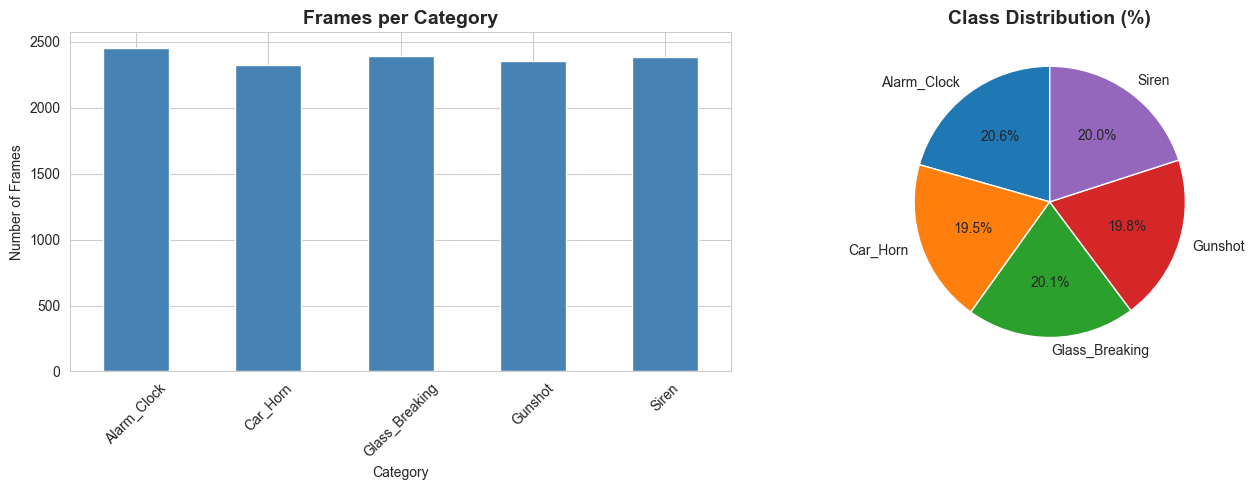

In [ ]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Frames per Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Frames')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# SAMPLE AUDIO FILES
print("\n" + "="*70)
print("AUDIO FILE VALIDATION (Sampling 5 files per category)")
print("="*70)

validation_results = defaultdict(list)
sample_stats = []

for category in CATEGORIES:
    cat_df = df[df['category'] == category]
    # Sample 5 files (including both original and augmented)
    sample_files = cat_df.sample(min(5, len(cat_df)))
    
    for _, row in sample_files.iterrows():
        file_path = row['frame_path']
        
        try:
            # Load .npy file
            audio = np.load(file_path)
            
            # Validate properties
            checks = {
                'shape': len(audio.shape) == 1,  # 1D array (mono)
                'length': len(audio) == EXPECTED_FRAME_SAMPLES,
                'dtype': audio.dtype in [np.float32, np.float64],
                'range': (audio.min() >= -1.0) and (audio.max() <= 1.0),
                'non_silent': np.abs(audio).max() > 0.001
            }
            
            all_pass = all(checks.values())
            validation_results[category].append(all_pass)
            
            # Collect stats
            sample_stats.append({
                'category': category,
                'file': os.path.basename(file_path),
                'samples': len(audio),
                'duration_s': len(audio) / TARGET_SR,
                'min_amp': audio.min(),
                'max_amp': audio.max(),
                'rms': np.sqrt(np.mean(audio**2)),
                'all_checks_pass': all_pass,
                **checks
            })
            
        except Exception as e:
            print(f"Error loading {os.path.basename(file_path)}: {e}")
            validation_results[category].append(False)

# Summary
stats_df = pd.DataFrame(sample_stats)
print("\nValidation Summary:")
for category in CATEGORIES:
    results = validation_results[category]
    pass_rate = (sum(results) / len(results) * 100) if results else 0
    status = "passed:" if pass_rate == 100 else "failed:"
    print(f"  {status} {category:15s}: {sum(results)}/{len(results)} passed ({pass_rate:.1f}%)")

# Detailed stats
print("\nSample Statistics:")
print(stats_df[['category', 'samples', 'duration_s', 'min_amp', 'max_amp', 'rms']].describe())

# Check failures
failed = stats_df[~stats_df['all_checks_pass']]
if not failed.empty:
    print("\nFailed Validations:")
    print(failed[['category', 'file', 'shape', 'length', 'range', 'non_silent']])
else:
    print("\nAll sampled files passed validation!")


AUDIO FILE VALIDATION (Sampling 5 files per category)

Validation Summary:
  passed: Alarm_Clock    : 5/5 passed (100.0%)
  passed: Car_Horn       : 5/5 passed (100.0%)
  passed: Glass_Breaking : 5/5 passed (100.0%)
  passed: Gunshot        : 5/5 passed (100.0%)
  passed: Siren          : 5/5 passed (100.0%)

Sample Statistics:
       samples  duration_s    min_amp    max_amp        rms
count     25.0       25.00  25.000000  25.000000  25.000000
mean   15360.0        0.96  -0.387981   0.396087   0.085629
std        0.0        0.00   0.166161   0.178893   0.020640
min    15360.0        0.96  -0.820259   0.173845   0.042397
25%    15360.0        0.96  -0.398177   0.277605   0.080000
50%    15360.0        0.96  -0.347135   0.369455   0.100000
75%    15360.0        0.96  -0.275499   0.447891   0.100000
max    15360.0        0.96  -0.181799   0.950000   0.100000

All sampled files passed validation!


In [ ]:
print("YAMNET COMPATIBILITY CHECK")

compatibility = {
    'Sample Rate': (TARGET_SR, 16000, TARGET_SR == 16000),
    'Frame Length': (EXPECTED_FRAME_SAMPLES, 15360, EXPECTED_FRAME_SAMPLES == 15360),
    'Audio Format': ('Mono', 'Mono', True),
    'Data Type': ('float32/64', 'float32/64', True),
    'Amplitude Range': ('[-1, 1]', '[-1, 1]', 
                       (stats_df['min_amp'].min() >= -1.0) and (stats_df['max_amp'].max() <= 1.0))
}

print("\nRequirement".ljust(20) + "Expected".ljust(15) + "Actual".ljust(15) + "Status")
print("-" * 60)
for req, (actual, expected, passed) in compatibility.items():
    status = "PASS" if passed else "FAIL"
    print(f"{req:20s}{str(expected):15s}{str(actual):15s}{status}")

all_compatible = all(c[2] for c in compatibility.values())
if all_compatible:
    print("DATASET IS READY FOR YAMNET FEATURE EXTRACTION")
else:
    print("DATASET REQUIRES FIXES BEFORE YAMNET PROCESSING")

YAMNET COMPATIBILITY CHECK

Requirement        Expected       Actual         Status
------------------------------------------------------------
Sample Rate         16000          16000          PASS
Frame Length        15360          15360          PASS
Audio Format        Mono           Mono           PASS
Data Type           float32/64     float32/64     PASS
Amplitude Range     [-1, 1]        [-1, 1]        PASS
DATASET IS READY FOR YAMNET FEATURE EXTRACTION


VISUAL INSPECTION (Sample Waveforms)


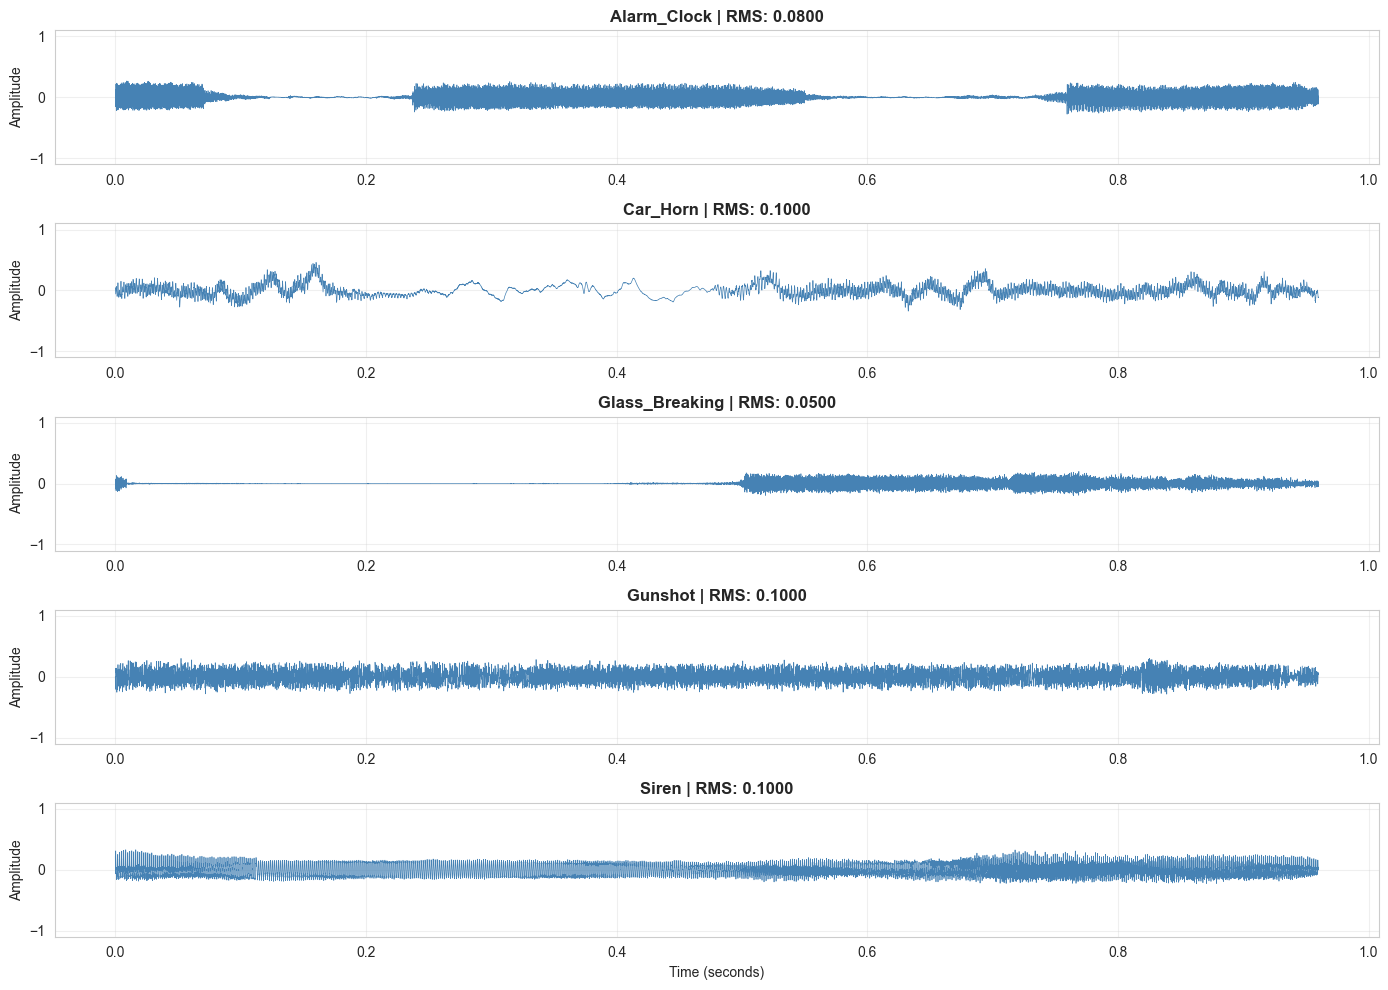

In [ ]:
# VISUAL INSPECTION (One example per category)
print("VISUAL INSPECTION (Sample Waveforms)")

fig, axes = plt.subplots(len(CATEGORIES), 1, figsize=(14, 10))

for idx, category in enumerate(CATEGORIES):
    cat_df = df[df['category'] == category]
    sample_row = cat_df.sample(1).iloc[0]
    audio = np.load(sample_row['frame_path'])
    
    time = np.linspace(0, len(audio) / TARGET_SR, num=len(audio))
    axes[idx].plot(time, audio, linewidth=0.5, color='steelblue')
    axes[idx].set_title(f"{category} | RMS: {np.sqrt(np.mean(audio**2)):.4f}", 
                       fontweight='bold')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_ylim([-1.1, 1.1])
    axes[idx].grid(True, alpha=0.3)
    
    if idx == len(CATEGORIES) - 1:
        axes[idx].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.show()


Generating spectrograms...


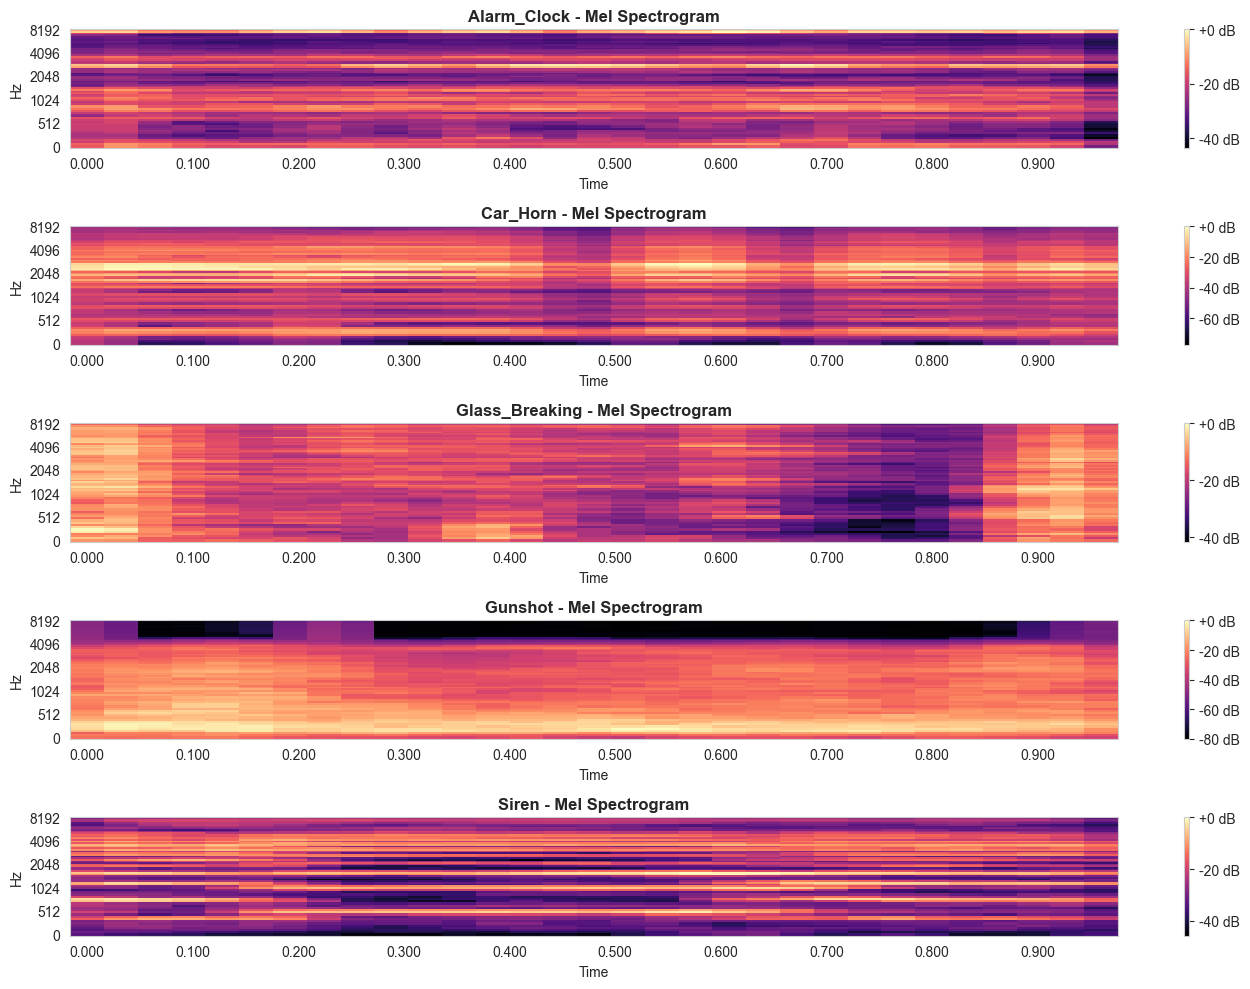

In [ ]:
# SPECTRAL ANALYSIS
print("\nGenerating spectrograms...")

fig, axes = plt.subplots(len(CATEGORIES), 1, figsize=(14, 10))

for idx, category in enumerate(CATEGORIES):
    cat_df = df[df['category'] == category]
    sample_row = cat_df.sample(1).iloc[0]
    audio = np.load(sample_row['frame_path'])
    
    # Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=TARGET_SR, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', 
                                    sr=TARGET_SR, fmax=8000, ax=axes[idx])
    axes[idx].set_title(f"{category} - Mel Spectrogram", fontweight='bold')
    fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
print("VALIDATION COMPLETE")
print(f"\nTotal frames validated: {len(df)}")
print(f"Categories: {', '.join(CATEGORIES)}")
print(f"YAMNet compatible: {'YES' if all_compatible else 'NO'}")

VALIDATION COMPLETE

Total frames validated: 11906
Categories: Alarm_Clock, Car_Horn, Glass_Breaking, Gunshot, Siren
YAMNet compatible: YES
